In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
DATA_PATH = 'data.pkl'

In [0]:
download = drive.CreateFile({'id': '1Q7vQ2SgsSucrMn-zNHS_D3RKJ3GjSZ5m'})
download.GetContentFile(DATA_PATH)

In [289]:
import pickle
import torch


with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
print(data.keys())
data['train'] = torch.FloatTensor(data['train']).permute(0, 3, 1, 2)
data['test'] = torch.FloatTensor(data['test']).permute(0, 3, 1, 2)

dict_keys(['train', 'test'])


In [0]:
from matplotlib import pyplot as plt

def show(images):
    images = images.permute(0, 2, 3, 1)
    fig=plt.figure(figsize=(8, 8))
    columns = images.shape[0]
    rows = 1
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img / 3)

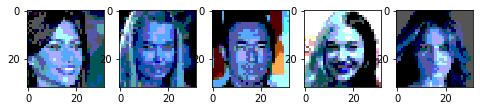

In [291]:
show(data['train'][:5])

In [0]:
from torch import nn


class Resnet(nn.Module):
    def __init__(self, ch_in, n_filters=256, n_blocks=8):
        super(Resnet,self).__init__()
        ch_out = ch_in * 2
        self.n_blocks = n_blocks
       # self.norm1 =  nn.BatchNorm2d(n_filters)
        self.conv1 = nn.Conv2d(ch_in, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=2)
        get_ht_model = lambda: nn.Sequential(
             nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters, n_filters, kernel_size=(1, 1), stride=(1, 1), padding=0),
            nn.ReLU(),
             nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=1),
        )
        get_h_model = lambda: nn.Sequential(
            nn.BatchNorm2d(n_filters),
            nn.Conv2d(n_filters, n_filters, kernel_size=(1,1), stride=(1, 1), padding=0),
            nn.ReLU()
        )
        self._h_model = torch.nn.ModuleList([get_ht_model() for _ in range(n_blocks)])
        self.h_model = torch.nn.ModuleList([get_h_model() for _ in range(n_blocks)])
        #self.h_sum = torch.nn.ModuleList([nn.ReLU() for _ in range(n_blocks)])
     #   self.norm2 =  nn.BatchNorm2d(n_filters)
        self.conv2 = nn.Conv2d(n_filters, ch_out, kernel_size=(3, 3), stride=(1, 1))
    
    def forward(self, x):
        h = self.conv1(x)
        for i in range(self.n_blocks):
            _h = self._h_model[i](h)
            h = self.h_model[i](_h)
            h = torch.cat((h, _h), dim=0)
        h = F.relu(h)
      #  h = self.norm2(h)
        x = self.conv2(h)
        return x

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, ch_in, sign):
        super(AffineCoupling, self).__init__()
        self.resnet = Resnet(ch_in)
        self.sign = sign
    
    def forward(self, x, masks):
        (x1, x2) = x
        y1 = x1
        log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
        y2 = torch.exp(log_s) * (x2 + t) # TODO: y1 or x2?
        log_det = log_s.view(x1.shape[0], -1).sum(dim=1) * self.sign
        return ((y1, y2), log_det)

    def reverse(self, y, mask):
        (y1, y2) = y
        x1 = y1
        log_s, t = torch.chunk(self.resnet(x1), 2, dim=1)
        x2 = y2 * torch.exp(-log_s) - t * (1 - mask[1])
        return (x1, x2)

In [0]:
import numpy as np
import torch.nn.functional as F

class CelebA(nn.Module):
  def __init__(self, ch_in):
      super(CelebA, self).__init__()
      self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
      signs = [1, 1, 1, 1] # TODO: maybe log_det_J after tuple flip must change signs?
      self.couplings1 = nn.ModuleList([AffineCoupling(ch_in, signs[i]) for i in range(4)])
      self.couplings2 = nn.ModuleList([AffineCoupling(ch_in * 4, signs[i]) for i in range(3)])
      self.couplings3 = nn.ModuleList([AffineCoupling(ch_in * 4, signs[i]) for i in range(3)])
      self.couplings4 = nn.ModuleList([AffineCoupling(ch_in * 16, signs[i]) for i in range(3)])
      self.couplings5 = nn.ModuleList([AffineCoupling(ch_in * 16, signs[i]) for i in range(3)])

  def build_mask(self, size, config=1.):
      mask = np.arange(size).reshape(-1, 1) + np.arange(size)
      mask = np.mod(config + mask, 2)
      mask = mask.reshape(-1, 1, size, size)
      return torch.tensor(mask.astype('float32'))

  def flip_tuple(self, x, masks):
      (x1, x2) = x
      (mask1, mask2) = masks
      return (x2, x1), (mask2, mask1)

  def checkerboard_split(self, x):
      mask = self.build_mask(x.shape[2], config=1.).to(device)
      return (x * mask, x * (1 - mask)), (mask, 1 - mask) # TODO: is it correct split?

  def inverse_checkerboard_split(self, x):
      return x[0] + x[1] # TODO: is it correct split?

  def squeeze(self, x):
      x = x.reshape(-1, 4 * x.shape[1], x.shape[2] // 2, x.shape[3] // 2)
      return x
  
  def unsqueeze(self, x):
      #x = x.permute(0, 2, 3, 1)
      #x = x.reshape(-1, x.shape[1] * 2, x.shape[2] * 2, x.shape[3] // 4)
      #x = x.permute(0, 3, 1, 2)
      x = x.reshape(-1, x.shape[1] // 4, x.shape[2] * 2, x.shape[3] * 2)
      return x

  
  def channel_split(self, x):
      mask = torch.zeros((1, x.shape[1], x.shape[2], x.shape[3])).to(device)
      mask[:, :mask.shape[1] // 2, :, :] = 1
      return (x * mask, x * (1 - mask)), (mask, 1 - mask)

  def inverse_channel_split(self, x):
      return x[0] + x[1]

  def forward(self, x):
      log_det = 0

      x, masks = self.checkerboard_split(x) 
      for i in range(4):
          x, log_det_temp = self.couplings1[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = self.inverse_checkerboard_split(x)

      x = self.squeeze(x)
      
      x, masks = self.channel_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings2[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = self.inverse_channel_split(x)
      x, masks = self.checkerboard_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings3[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = self.inverse_checkerboard_split(x)
      
      x = self.squeeze(x)
      
      x, masks = self.channel_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings4[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = self.inverse_channel_split(x)

      x, masks = self.checkerboard_split(x)
      for i in range(3):
          x, log_det_temp = self.couplings5[i](x, masks)
          log_det += log_det_temp
          x, masks = self.flip_tuple(x, masks)
      x = self.inverse_checkerboard_split(x)

      #x = self.unsqueeze(self.unsqueeze(x)) # TODO: Is it correct to do so?

      return x, log_det
    
  def reverse(self, z):
      x = z
      #x = self.squeeze(self.squeeze(x))
      
      x, masks = self.checkerboard_split(x)
      for i in range(3):
          x, masks = self.flip_tuple(x, masks)
          x = self.couplings5[i].reverse(x, masks)
      x = self.inverse_checkerboard_split(x)

      x, masks = self.channel_split(x)
      for i in range(3):
          x, masks = self.flip_tuple(x, masks)
          x = self.couplings4[i].reverse(x, masks)
      x = self.inverse_channel_split(x)

      x = self.unsqueeze(x)

      x, masks = self.checkerboard_split(x)
      for i in range(3):
          x, masks = self.flip_tuple(x, masks)
          x = self.couplings3[i].reverse(x, masks)
      x = self.inverse_checkerboard_split(x)

      x, masks = self.channel_split(x)
      for i in range(3):
          x, masks = self.flip_tuple(x, masks)
          x = self.couplings2[i].reverse(x, masks)
      x = self.inverse_channel_split(x)
      
      x = self.unsqueeze(x)
      
      x, masks = self.checkerboard_split(x) 
      for i in range(4):
          x, masks = self.flip_tuple(x, masks)
          x = self.couplings1[i].reverse(x, masks)
      x = self.inverse_checkerboard_split(x)

      return x
    
  def log_prob(self, x):
      z, log_det_J = self(x)
      log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
      return log_prior_prob + log_det_J

  def loss(self, batch):
      return torch.mean(-self.log_prob(batch)) / np.log(2) / 2
  
  def sample(self, size):
        #z = self.prior.sample((size, 3, 32, 32))
        z = self.prior.sample((size, 48, 8, 8))
        return self.reverse(z)

In [296]:
#import torch_xla_py.xla_model as xm
device = 'cuda'
from tqdm import tqdm

epochs = 8

train_iter = torch.utils.data.DataLoader(data['train'], batch_size=64, shuffle=True)
val_iter = torch.utils.data.DataLoader(data['test'], batch_size=64, shuffle=True)

losses = []
val_losses = []

model = CelebA(3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

for epoch in range(epochs):
    tmp_losses = []
    
    for batch in tqdm(train_iter):
        loss = model.loss(batch.to(device))
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.cpu().numpy())
        tmp_losses.append(loss.data.cpu().numpy())

    with torch.set_grad_enabled(False):
        tmp_val_losses = []
        for batch in val_iter:
            val_loss = model.loss(batch.to(device))
            val_losses.append(val_loss.data.cpu().numpy())
            tmp_val_losses.append(val_loss.data.cpu().numpy())

    if epoch % 1 == 0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,np.mean(tmp_losses),np.mean(tmp_val_losses)))


import matplotlib.pyplot as plt

plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

RuntimeError: ignored